In [1]:
import mud.funs as mdf

# Array handling libraries
import numpy as np
import pandas as pd
import xarray as xr

import datetime 

# Statistics libraries
from scipy.stats import uniform, norm
from scipy.stats import gaussian_kde as GKDE
from scipy.integrate import odeint

# Plotting libraries
import matplotlib.pyplot as plt

In [ ]:
# Default formatting for plots
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

## <center> Maximal Updated Density (MUD) point estimate inverse problems 
   --- 
Carlos del-Castillo-Negrete
    <br>
    Oden Institute at the University of Texas at Austin
    <br>
    cdelcastillo21@gmail.com 
    
   ---
</center>
    
Based off work from Troy Butler and Michael Pilosov

## Exponential Decay - Single Parameter Estimation Problem 
Consider an exponential decay system with uncertain paramater $\lambda$, which we model with the following differential equation.


<center>
\begin{equation}
\Large
\begin{cases} \frac{\partial u}{\partial t} = \lambda u(t), 0 \lt t \leq 3, \\
                  u(0) = 0.75
\end{cases}
\end{equation}
</center>

The true solution is given by the following equation. 
    
<center>
\begin{equation}
\Large u(t; \lambda) = u_0 \text{exp}(-\lambda t), u_0 = 0.75 
\end{equation}
<\center>

### Goal and assumptions
Our goal is to use any initial knowledge on our parameter space, the assumed exponential decay model above, and data collected from experiments on the real world system to infer the true value $\lambda$, which we set for this example problem to $\lambda^{\dagger}=0.5$. We seek a point estimate of the this true value.

The main assumption we make is that our model is indeed an accurate representation of the physical system we are measuring, and the uncertainties in our experiments are aleatoric, i.e. reducible. Thus we have a noisy measurement device $M(t;\lambda^{\dagger})$ to record the true signal $u(t;\lambda^{\dagger})$ at $N$ points in time, with errors being idenpendent identically distributed Gaussain errors. The data collected can then be described by:

<center>
    \begin{equation}
        \label{eq:d_i}
        \Large d(t_i) = M(t_i, \lambda^{\dagger}) + \xi_i, \xi_i \sim {\mathcal N}(0, \sigma^2), 1 \leq i \leq N
    \end{equation}
</center>

Our goal is to use any initial knowledge on our parameter space, the assumed exponential decay model above, and data collected from our measurement device to infer the true value $\lambda^{\dagger}$. We will do this by building a Quantity of Interest map $Q$ from our observed data and perform data-consistent inversion to compute the updated probability density on our parameter space, given by the following equation

<center>
    \begin{equation}
        \Large
        \pi_{up}(\lambda) = \pi_{in}(\lambda)\frac{\pi_{ob}(Q(\lambda))}{\pi_{pr}(Q(\lambda))}
    \end{equation}
</center>

Here $\pi_{pr}(Q(\lambda))$ corresponds to the push-forward of the initial distribution on our parameter space through the QoI map, while $\pi_{ob}(Q(\lambda))$ is the observed distribution of the QoI map for our system. From the $\pi_{up}(\lambda)$ we can then compute the <bf>Maximal Updated Density</bf> (MUD) point as

<center>
    \begin{equation}
        \Large
        \lambda^{MUD} := \text{argmax}\pi_{up}(\lambda)
    \end{equation}
</center>

Finall for our model problem, we assume our parameter range to be $\Lambda = [0,1]$ and a uniform initial distribution, $\pi_{in}(\lambda)={\mathcal U}([0,1])$.

In [ ]:
def exp_decay_one(u_0=0.75, time_range=[0, 3.0], domain=[0,1 ], num_samples=10000, lambda_true=0.5, N=20, t_start=1.0, sampling_freq=100.0):
    
    time = np.linspace(time_range[0],time_range[1],1000)
    times = np.arange(t_start, time_range[1], 1/sampling_freq)[0:N]
    
    u_t_lambda = lambda t, l: u_0*np.exp(-np.outer(l, t))    

    mn = np.min(domain, axis=1)
    mx = np.max(domain, axis=1)
    initial = uniform(loc=mn, scale=mx - mn)
    lambda_samples = initial.rvs(size=num_samples)

    true = u_t_lambda(times, lambda_true)[0]
    predicted = u_t_lambda(times, lambda_samples)

    return times, lambda_samples, predicted, true

In [ ]:
# Scenario 1 -> Take 30 measurements at 10 Hz starting at t=0
u_0 = 0.75                # Initial condition
time_range = [0, 10.0]    # Time range (secs)
domain = [[0, 1]]         # Domain of possible lambda values
lambda_true = 0.5         # True value of lambda
num_samples = 100         # Number of parameter samples. 
N = 30                    # Number of measurements from sample/true trajectories to take.
t_start = 0.0             # Time at which to start taking measurements (secs)
sampling_freq = 100.0     # Sampling frequency (Hz)
sd = np.sqrt(1.507e-3)    # Std Deviation for adding noise to measurements  

In [67]:
ts, lam, qoi, qoi_true = exp_decay_one(u_0=u_0,
                                       time_range=time_range,
                                       domain=domain,
                                       lambda_true=lambda_true,
                                       num_samples=num_samples,
                                       N=N,
                                       t_start=t_start,
                                       sampling_freq=sampling_freq)
ts.shape, lam.shape, qoi.shape, qoi_true.shape

((30,), (100,), (100, 30), (30,))

In [10]:
# Build and solve mud problem
exp_decay_mud = mdf.mud_problem(domain=domain, 
                                 lam=lam, 
                                 qoi=qoi, 
                                 sd=sd, 
                                 qoi_true=qoi_true, 
                                 num_obs=N)
exp_decay_mud.estimate()

array([0.51226471])

In [11]:
# Scenario 1 -> Split previous data into 3 iterations of 10 measurements at 10 Hz starting at t=0
# Use weights from previous iteration to weigh next iteration.
num_splits = 3
ts_it = np.split(ts, num_splits)
qoi_it = np.split(qoi, num_splits, axis=1)
qoi_true_it = np.split(qoi_true, num_splits)

weights = None
mud_solves = []
for i in range(num_splits):
    mud_it = mdf.mud_problem(domain=domain, 
                            lam=lam, 
                            qoi=qoi_it[i], 
                            sd=sd, 
                            qoi_true=qoi_true_it[i], 
                            num_obs=int(N/num_splits),
                            weights=weights)
    res = mud_it.estimate()
    
    print(f"Lambda estimate = {res}")
    weights = mud_it._r
    mud_solves.append(mud_it)

Lambda estimate = [0.9700813]
Lambda estimate = [0.60955897]
Lambda estimate = [0.3443892]


## Modelling Predator-Prey Systems in Python
    
We will now consider predator-prey systems. Specifically we will be looking at the __Lotka-Volterra__ model., We will evaluate both a __deterministic__, idealized model for the predator-prey systems, and a __stochastics__ into the equations - so that the model more accurately captures the noise found in real world scenarios.

### The Lotka-Volterra Equations


<center>
\begin{equation}
\Large
\begin{cases}
\dfrac{dx}{dt} = \alpha x - \beta x y \qquad 0\leq t\leq 50\\
\dfrac{dy}{dt} = \delta xy - \gamma y \\
x(0) = 100, \ y(0)= 20
\end{cases}
\end{equation}
</center>



We interpret the quantities above as:

* $\dfrac{dx}{dt}$ = Growth rate of prey population,
* $\dfrac{dy}{dt}$ = Growth rate of predator population,
* $x$ = Prey population ,
* $y$ = Pedator population,
* $\alpha$ = Growth rate of prey,
* $\beta$ = Death rate of prey due to predatation from predator,
* $\gamma$ = Natural death rate of predators,
* $\delta$ = Factor describing how many consumed prey create a new predator,

### Goals and Assumptions

Lotka-Volterra model makes several assumptions for the dynamics of predator-prey systems. Some of which are as follows:

* Prey population is provided with an unlimited food supply,
* The rate of change of the populations are proportional to their size,
* Predators only consume prey, and are entirely dependent on them as a food source,
* Predators have unlimited consumption capacity,

The system is evaluated via an explicit forward euler equation that evaluates the given current differentials and then evaluates the next value of the new states using the previously computed differentials.We assume our parameter ranges to be $\beta = [0,0.5]$ and $\Gamma = [0.5,0.7]$ with intial uniform initial distributions, 
$\pi_{in}(\beta)={\mathcal U}([0,0.5])$, and $\pi_{in}(\gamma)={\mathcal U}([0,0.8])$


In [2]:
def lv_model(alpha, beta, gamma, delta, xinit=100, yinit=20, dt=0.001, tinit=0, tfinal=50,seasonal=False):
    """
    Parameters:
    ------------
    :param alpha: float, birth rate of prey
    :param beta:  float, death rate of prey due to predation
    :param gamma: float, natural death rate of predator
    :param delta: float, factor that describes how many eaten prey give birth to a new predator
    :param xinit: float, i.c. for the prey (x) population at time=0
    :param yinit: float, i.c. for the predator (y) population at time=0
    :param dt:    float, timestep determines the accuracy of the euler method of integration
    :param tinit: int,   initial time for simulation
    :param tfinal: int,  stopping time for simulation
    :param seasonal: bool, seasonal assumption to perturb beta parameter
    
    Returns:
    --------
    : time series data
    : x and y state vectors time series data
    """
    
    t = np.arange(0,tfinal,dt) # create temporal domain vector
    x=[xinit]; y=[yinit]       # initial conditions for populations

    for n in range(1,len(t)):
        
        if seasonal and n == len(t)//2:
            beta = .5; gamma =0.7
            
        dx = x[n-1] * (alpha - beta*y[n-1])
        dy = -y[n-1]*(gamma - delta*x[n-1])

        xnew = x[n-1] + dx * dt
        ynew = y[n-1] + dy * dt

        x.append(xnew); y.append(ynew)
        
    return t, np.asarray(x), np.asarray(y)


def pp_sampler(a,b,c,d,uscale, nsamps=100):
    """
    Parameters:
    ----------
    :param nsamps: int,  number of paramter samples to draw from uniform rv
    :param uscale: np array, supports of parameters given as uniform rv ~ U[0,uscale]
    
    Returns:
    ----------
    :parameter samples sampled from uniform distribution
    :time series of forward model run for each sample
    """
    
    a_samps = uniform.rvs(0,uscale[0],size=nsamps)
    b_samps = uniform.rvs(0,uscale[1],size=nsamps)
    g_samps = uniform.rvs(0, uscale[2],size=nsamps)
    d_samps = uniform.rvs(0,uscale[3],size=nsamps)

    xtemp=list(); ytemp = list()

    for i in range(nsamps):

        _, xf, yf =  lv_model(a_samps[i],b_samps[i],g_samps[i],d_samps[i])
        xtemp.append(xf); ytemp.append(yf)

    return a_samps, b_samps, g_samps, d_samps, np.asarray(xtemp), np.asarray(ytemp)


def sub_sample(samples,sfreq=4):
    """
    Parameters:
    ------------
    :param samples: np array, samples
    :param sfreq:   int,  sampling fequency
    
    Returns:
    --------
    :copy of np array subsampled according to given subsample frequency
    """
    if len(samples.shape)==1:
        return samples[0::sfreq].copy()
    return samples[:,0::sfreq].copy()


def pp_plot(time, x_true, y_true, n_plots=2):
    """
    Plot time series of parameter before perterbation
    Plot time series of parameter after perterbation
    """
    
    half = len(t)//2
    
    fig, (ax1, ax2) = plt.subplots(1,n_plots,figsize=(14,8))

    ax1.plot(time[:half], x_true[:half])
    ax1.plot(time[:half], y_true[:half])
    ax1.set_xlabel('Time',fontsize=14); ax1.set_ylabel('Population Size',fontsize=14)
    ax1.legend(('Prey', 'Predator'))
    # ax1.legend.get_frame().set_alpha(0.5)
    ax1.set_title('Deterministic Lotka-Volterra Before Perterbation',fontsize=18)
    ax1.grid(True)
    
    ax2.plot(time[half:], x_true[half:])
    ax2.plot(time[half:], y_true[half:])
    ax2.set_xlabel('Time',fontsize=14); ax2.set_ylabel('Population Size',fontsize=14)
    ax2.legend(('Prey', 'Predator'))
    # ax2.legend.get_frame().set_alpha(0.5)
    ax2.set_title('Deterministic Lotka-Volterra After Perterbation',fontsize=18)
    ax2.grid(True)
    
    fig.tight_layout()
    plt.show()

def mud_prob(domain, samps, qi,std, qi_true, nobs):
    """
    instantiate mud object to build and solve mud problem
    """
    return mdf.mud_problem(domain=domain, 
                                 lam=samps, 
                                 qoi= qi,
                                 sd=std, 
                                 qoi_true= qi_true, 
                                 num_obs= nobs)

In [3]:
""""lotka-volterra parameters"""

atrue, btrue, gtrue, dtrue = 1, 0.1, 0.5, 0.02    
season = True
umax=np.array([2,0.5,0.8,0.1])

t, xtrue, ytrue = lv_model(atrue,btrue,gtrue,dtrue,seasonal=season)

asamples, bsamples, gsamples, dsamples, xsamples, ysamples = pp_sampler(atrue,btrue,gtrue,dtrue,umax)

In [ ]:
""" Sub-sample data for different observation times"""

xtrue_sub = sub_sample(xtrue)
ytrue_sub = sub_sample(ytrue)
xsamp_sub = sub_sample(xsamples)
ysamp_sub = sub_sample(ysamples)

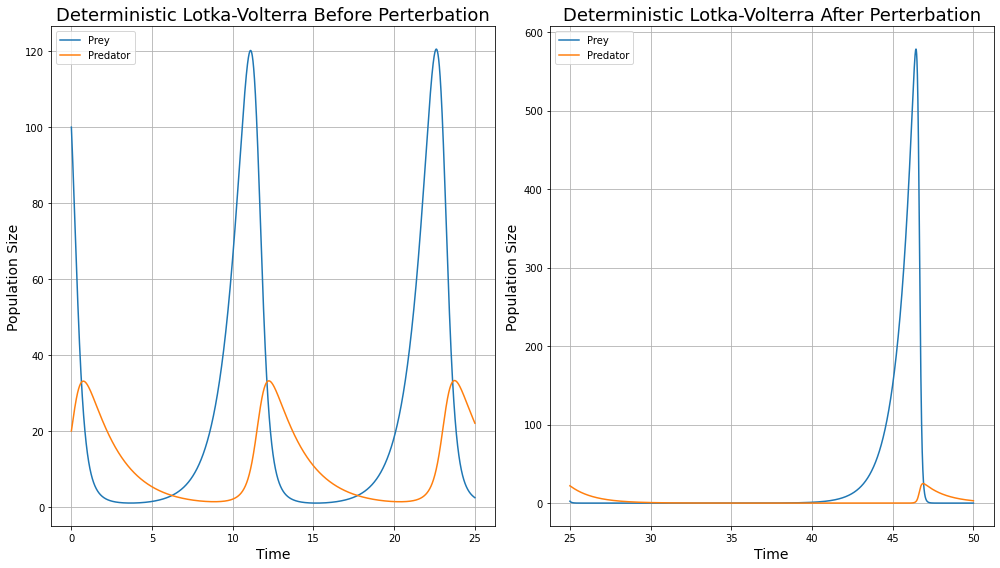

In [81]:
""" Plot True states """

pp_plot(t,xtrue,ytrue)

In [83]:
""" Build and Solve Mud Problems """

std_dev =0.05; N=20
adomain=np.array([0,2])
bdomain=np.array([0,0.5])
gdomain=np.array([0,0.8])
ddomain=np.array([0,0.1])

pred_prey_muda = mud_prob(adomain,asamples,xsamp_sub, std_dev, xtrue_sub,N)
pred_prey_mudb = mud_prob(bdomain,bsamples,xsamp_sub, std_dev, xtrue_sub,N)
pred_prey_mudg = mud_prob(gdomain,gsamples,ysamp_sub, std_dev, ytrue_sub,N)
pred_prey_mudd = mud_prob(ddomain,dsamples,ysamp_sub, std_dev, ytrue_sub,N)

print(pred_prey_muda.estimate(),pred_prey_mudb.estimate(), pred_prey_mudg.estimate(), pred_prey_mudd.estimate())

[1.07710331] [0.09328037] [0.47963839] [0.02334524]


In [55]:
""" Create 2D state vectors """

true_states = np.concatenate((xtrue_sub.reshape(-1,1),ytrue_sub.reshape(-1,1)),axis=1)
states = np.concatenate((xsamp_sub.T,ysamp_sub.T),axis=1)

print("2D Sampled State Array: ", states.shape, "2D True State Array: " ,true_states.shape)

2D Sampled State Array:  (12500, 200) 2D True State Array:  (12500, 2)


In [ ]:
N=10;std_dev =0.05

domain=np.array([[0,0.5],[0.5,0.7]])

pred_prey_mud2d = mud_prob(domain,bsamples,states, std_dev, true_states,N)
pred_prey_mud2d.estimate()

In [36]:
def sir(ndays= 150, I0=1, R0=0, beta = 0.2, gamma =  0.1 ,N=10000,dt=0.5):
    """
    Integrates the SIR equations over the time grid, t.

    Parameters:
    -------------
    :param ndays: int, number of days to run model
    :param I0:  int, initial number of infected individuals
    :param R0:  int, initial number of recovered individuals
    :param beta: float, contact rate
    :param gamma: float, recovery rate
    :param N:     int,   total population

    Returns:
    ---------
    np arrays: time data, S, I, R
    """

    
    t = np.arange(0, ndays, dt)   # grid of time points (in days)
    s = np.zeros(int(ndays/dt))
    i = np.zeros(int(ndays/dt))
    r = np.zeros(int(ndays/dt))
    
    s[0] = N - I0 - R0                   # initial susceptible
    i[0] = I0
    r[0] = R0
    
    for n in range(1, len(t)):
        
        ds = -(beta * i[n-1] * s[n-1])/N
        di = (beta * i[n-1] * s[n-1])/N - gamma*i[n-1]
        dr = gamma * i[n-1]
        
        s[n] = s[n-1] + dt*ds
        i[n] = i[n-1] + dt*di
        r[n] = r[n-1] + dt*dr

    return t, s, i, r

def sir_sampler(uscale, nsamps=100):
    """
    Parameters:
    ----------
    :param nsamps: int,  number of paramter samples to draw from uniform rv
    :param uscale: np array, supports of parameters given as uniform rv ~ U[0,uscale]
    
    Returns:
    ----------
    :parameter samples sampled from uniform distribution
    :time series of forward model run for each sample
    """
    
    b_samps = uniform.rvs(0,uscale[0],size=nsamps)
    g_samps = uniform.rvs(0,uscale[1],size=nsamps)

    stemp, itemp, rtemp = list(),list(),list()

    for j in range(nsamps):
        _, S,I,R = sir(beta=b_samps[j], gamma=g_samps[j])
        stemp.append(S); itemp.append(I), rtemp.append(R)

    return b_samps, g_samps, np.asarray(stemp), np.asarray(itemp), np.asarray(rtemp)

def sir_plot(time,s,i,r):
    """
    Plot the data on three separate curves for S(t), I(t) and R(t)
    """
    fig = plt.figure(facecolor='w',figsize=(12,8))
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(time, s, 'b', alpha=0.5, lw=2, label='$S(t)$ Susceptible')
    ax.plot(time, i, 'r', alpha=0.5, lw=2, label='$I(t)$ Infected')
    ax.plot(time, r, 'g', alpha=0.5, lw=2, label='$R(t)$ Recovered w/ immunity')
    ax.set_xlabel('Time /days',fontsize =14)
    ax.set_ylabel('Number (1000s)',fontsize=14)
    # ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(fontsize=10)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()
    

In [37]:
""""sir parameters"""

bet_true, gam_true = 0.2, 0.1,    
season = True
umax=np.array([.5,.5])

time,S,I,R = sir()

bsamples, gsamples,  ssamples, isamples, rsamples = sir_sampler(uscale=umax)

/tmp/ipykernel_1538/241788185.py:81: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


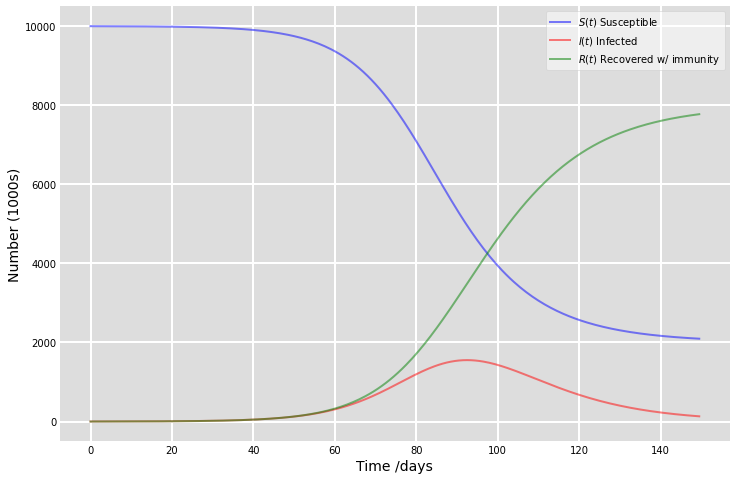

In [38]:
""" Plot True states """
sir_plot(time,S,I,R)

In [39]:
""" Sub-sample data for different observation times"""

strue_sub = sub_sample(S)
ssamp_sub = sub_sample(ssamples)

itrue_sub = sub_sample(I)
isamp_sub = sub_sample(isamples)

rtrue_sub = sub_sample(R)
rsamp_sub = sub_sample(rsamples)

In [40]:
""" Build and Solve Mud Problems """

std_dev =0.05; N=20
betdomain=np.array([0,0.5])
gamdomain=np.array([0,0.5])

s_mud = mud_prob(betdomain,asamples,ssamp_sub, std_dev, strue_sub,N)
i_mud = mud_prob(gamdomain,bsamples,isamp_sub, std_dev, itrue_sub,N)
r_mud = mud_prob(gamdomain,bsamples,rsamp_sub, std_dev, rtrue_sub,N)

print(s_mud.estimate(),i_mud.estimate(), r_mud.estimate())

[1.78010387] [0.35869642] [0.47018978]
